## ANÁLSIS EXPLORATORIO DE DATOS

A continuación se presenta el resultado de un análisis preliminar de los datos y de la calidad de los mismos

In [1]:
# PARTE 1: LIBRERIAS Y FUNCIONES A USAR - METADATA SETUP
# NOTA: es importante para este proceso que se tengan instaladas las librerias antes de usarlas

from sodapy import Socrata
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
#Construccion del cliente
client = Socrata("www.datos.gov.co",None)

#ejecución de la consulta
#Nota: Dado el tamaño de la base datos, se requiere un computador con alto poder de procesamiento para trabajar con
#      esa base, por tanto se va a separar la información tomando únicamente los últimos 6 años
diasAtras = 2190
hoy = dt.datetime.now()
hoy = hoy.replace(minute=0,hour=0,second=0,microsecond=0)
anterior = hoy - dt.timedelta(days=diasAtras)
ano = anterior.strftime("%Y")
mes = anterior.strftime("%m")
dia = anterior.strftime("%d")
fechaRef = ano + "-" + mes + "-" + dia + "T00:00:00.000"

results = client.get("gpzw-wmxd",limit=2000000,where='fecha_corte>=\"'+ fechaRef +'\"')  
datosBrutos = pd.DataFrame.from_records(results)

#otros archivos a usar
nomFondo = pd.read_csv('NomFondo.txt', sep=';')

In [3]:
#MAIN -------------------------------
#---------------------
#PARTE 2: Ajustes a los Datos
# 2.1 Organizando la Base de datos
#     Se Limpian algunas columnas innecesarias, se cambian nombres de columna más sencillos para trabajarlos adelante
try:
    datosBrutos = datosBrutos.drop(['nombre_tipo_entidad',
                                    'nombre_entidad',
                                    'tipo_patrimonio',
                                    'nombre_tipo_patrimonio',
                                    'subtipo_patrimonio',
                                    'nombre_subtipo_patrimonio',
                                    'valor_fondo_cierre_dia_t', #valor del fondo en unidades
                                    'rendimientos_abonados_dia', #rendimientos del día 
                                    'precio_cierre_fondo_dia_t', #realmente es el precierrre del dia t
                                    'rentabilidad_30_dias',
                                    'rentabilidad_180_dias',
                                    'rentabilidad_360_dias'], axis=1)
except:
    print('WARNING: Hay columnas que no se encontraron en el ingreso de la base punto2.1')

datosBrutos = datosBrutos.rename(columns={'fecha_corte':'Fecha',
                                          'tipo_entidad':'TipEnt',
                                          'codigo_entidad':'CodEnt',
                                          'codigo_patrimonio':'CodFdo',
                                          'nombre_patrimonio':'NomFdo',
                                          'valor_fondo_cierre_dia_t_1':'VlrCierreAyer',
                                          'valor_unidad_operaciones':'VlrUnd',
                                          'aportes_traslados_recibidos':'MovClient',
                                          'traslados_aportes_valor_pesos':'MovCorp',
                                          'mesada_pensionales_valor':'MovPens',
                                          'retiros_aportes_dif_mesada':'MovDifPens',
                                          'otras_comisiones_valor_pesos':'OtrasComis',
                                          'traslados_aseguradoras_rentas':'MovRentVital',
                                          'otros_retiros_valor_pesos':'MovOtros',
                                          'anulaciones_valor_pesos':'Anulaciones',
                                          'valor_fondo_cierre_dia_t_2':'VlrCierre'})
#    La columna de fecha viene en formato de texto por tanto se transforma
datosBrutos['Fecha'] = datosBrutos['Fecha'].str[:10]
datosBrutos['Fecha'] = pd.to_datetime(datosBrutos['Fecha'])
#   Agunas columnas deben cambiar el tipo de dato para trabajar con ellos más adelante
datosBrutos['CodEnt'] = datosBrutos['CodEnt'].astype('float')
datosBrutos['CodFdo'] = datosBrutos['CodFdo'].astype('float')
datosBrutos['VlrCierre'] = datosBrutos['VlrCierre'].astype('float')
datosBrutos['VlrCierreAyer'] = datosBrutos['VlrCierreAyer'].astype('float')
datosBrutos['MovClient'] = datosBrutos['MovClient'].astype('float')
datosBrutos['MovDifPens'] = datosBrutos['MovDifPens'].astype('float')
datosBrutos['VlrUnd'] = datosBrutos['VlrUnd'].astype('float')
datosBrutos['OtrasComis'] = datosBrutos['OtrasComis'].astype('float')
datosBrutos['MovRentVital'] = datosBrutos['MovRentVital'].astype('float')
datosBrutos['MovOtros'] = datosBrutos['MovOtros'].astype('float')
datosBrutos['Anulaciones'] = datosBrutos['Anulaciones'].astype('float')
datosBrutos['MovCorp'] = datosBrutos['MovCorp'].astype('float')
datosBrutos['MovPens'] = datosBrutos['MovPens'].astype('float')

In [4]:
# 2.2 Agregando algunas columnas que seran necesarias a futuro
#   Se inserta como columna en año, mes, dia, diaSem
datosBrutos['Ano'] = datosBrutos['Fecha'].dt.strftime('%Y')
datosBrutos['Mes'] = datosBrutos['Fecha'].dt.strftime('%b')
datosBrutos['Dia'] = datosBrutos['Fecha'].dt.strftime('%d')
datosBrutos['DiaStr'] = datosBrutos['Fecha'].dt.strftime('%a')


In [5]:
# 2.3 La base trae un registro por cada compañia a diario que resume todos los fondos
#     de esa empresa, sin embargo esto no es conveniente para el análisis por lo que se
#     va a eliminar esto usando una base que ya contiene definidos quienes son esos fondos en particular
#--812.747
datosBrutos = datosBrutos.merge(nomFondo[['CodEnt',
                                          'FdoTot']],
                                how='left',
                                left_on=['CodEnt','CodFdo'],
                                right_on=['CodEnt','FdoTot'])
#--812.747 Check
datosBrutos = datosBrutos[datosBrutos['FdoTot'].isna()]
#--787.653
datosBrutos.drop('FdoTot', inplace=True, axis=1)

#    puede que en el pasado hayan existido entidades que hoy en dia no, por ello se deben eliminar

#--789.626
datosBrutos = datosBrutos.merge(nomFondo[['CodEnt',
                                          'Nombre']],
                                how='left',
                                on='CodEnt')
#--789.626 Check
datosBrutos = datosBrutos[datosBrutos['Nombre'].notnull()]
datosBrutos.drop('Nombre', inplace=True, axis=1)

In [6]:
#2.4 Identificación de datos Nulos por cada compañia 

#    quitamos duplicados por compañia para saber que días la compañia no subio información
#    se asume que: o Sube todo o no sube nada por fondo
datosUnicos = datosBrutos[['Fecha', 'CodEnt']].drop_duplicates()

#    se cruza para tener el nombre de la empresa
datosUnicos = datosUnicos.merge(nomFondo[['CodEnt','Nombre']],
                                on='CodEnt',
                                how='left')
datosUnicos = pd.pivot_table(datosUnicos,
                             index=['Nombre','CodEnt'],
                             values='Fecha',
                             aggfunc='count').reset_index()
datosUnicos = datosUnicos.rename(columns={'Fecha':'ConteoRg'})
datosUnicos['PctNulos'] = (1 - datosUnicos['ConteoRg'] / diasAtras)
datosUnicos.sort_values('PctNulos', ascending=False, inplace=True)
print(datosUnicos)

             Nombre  CodEnt  ConteoRg  PctNulos
5       Coomeva Fcd    62.0       828  0.621918
12      Renta4g Fcd    63.0      1105  0.495434
3           BTG Fcd    61.0      1587  0.275342
8           GNB Fcd    34.0      2032  0.072146
2   Allianz Seguros     1.0      2168  0.010046
6     Credicorp Fcd    59.0      2177  0.005936
1       Alianza Fcd    16.0      2180  0.004566
10         Porvenir     3.0      2184  0.002740
11       Proteccion     2.0      2184  0.002740
0        Accion Fcd    33.0      2185  0.002283
4         Colfondos    10.0      2185  0.002283
7    Davivienda Fcd    42.0      2185  0.002283
9       Popular Fcd    18.0      2185  0.002283
13          Skandia     9.0      2185  0.002283


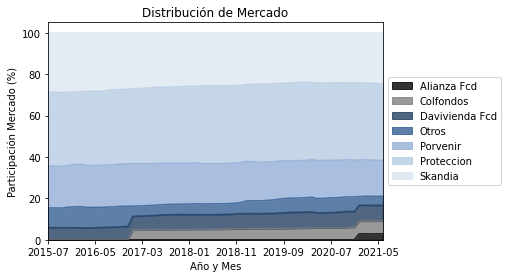

In [7]:
#----------------------
#PARTE 3 : Initial Data Analysis
# 3.1 Cómo se ha distribuido los activos administrados por compañía en los últmos 6 años?
activosAdm = pd.pivot_table(datosBrutos, 
                            index=['CodEnt','Fecha'],
                            values='VlrCierre',
                            aggfunc='sum').reset_index()
#     se calcula nuevamente una columna para año y mes de tal forma que se pueda calcular un promedio
#     del monto diario que se mantuvo en el mes
activosAdm['Ano'] = activosAdm['Fecha'].dt.strftime('%Y')
activosAdm['Mes'] = activosAdm['Fecha'].dt.strftime('%m')
activosAdm['AnoMes'] = activosAdm['Ano'] + '-' + activosAdm['Mes']

#    se agrupa por año y mes el promedio de recursos administrados
activosAdm = pd.pivot_table(activosAdm,
                            index=['AnoMes','CodEnt'],
                            values='VlrCierre',
                            aggfunc='mean').reset_index()
#    se pone un nombre de entidad
activosAdm = activosAdm.merge(nomFondo[['CodEnt','Nombre']],
                              how='left',
                              on='CodEnt')
#    Todas las entidades que administren menos de 800.000 Mill las agrupamos en "otras"
activosAdm.loc[activosAdm['VlrCierre']<800000000000,'Nombre'] = 'Otros'

#--916

#    se normaliza para cada periodo el porcentaje de participacion por cia
tempTot = pd.pivot_table(activosAdm,
                         index='AnoMes',
                         values='VlrCierre',
                         aggfunc='sum').reset_index()
tempTot.rename(columns={'VlrCierre':'TotMdo'}, inplace=True)
activosAdm = activosAdm.merge(tempTot,
                              how='left',
                              on='AnoMes')
del(tempTot)
activosAdm['PctPart'] = activosAdm['VlrCierre'] / activosAdm['TotMdo'] * 100
#--916 Check
activosAdm.sort_values('PctPart',inplace=True, ascending=False)
#activosAdm.to_excel('vlrMdo.xlsx')
activosAdm = pd.pivot_table(activosAdm,
                            index='AnoMes',
                            values='PctPart',
                            columns='Nombre',
                            aggfunc='sum',
                            fill_value=0)
ax = activosAdm.plot(kind='area', 
                     stacked=True,
                     alpha=0.8,
                     color=["#000000","#808080",
                            "#244062","#365f92",
                            "#95b0d7","#b8cce4",
                            "#dce6f1"]) #viridis #tab20c

ax.set_ylabel('Participación Mercado (%)')
ax.set_xlabel('Año y Mes')
ax.set_title('Distribución de Mercado')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

del(activosAdm)

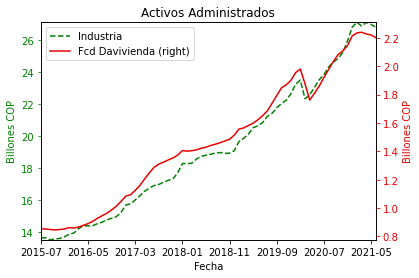

In [8]:
#3.2 Para ejemplificar el valor del total de recursos invertidos, con el fin de mostrar que
#    la distribucion del mercado es homogenea a pesar de que se tengan desvalorizacionews
#dato diario de AUM
activosAdm = pd.pivot_table(datosBrutos, 
                            index=['CodEnt','Fecha'],
                            values='VlrCierre',
                            aggfunc='sum').reset_index()
activosAdm['Ano'] = activosAdm['Fecha'].dt.strftime('%Y')
activosAdm['Mes'] = activosAdm['Fecha'].dt.strftime('%m')
activosAdm['AnoMes'] = activosAdm['Ano'] + '-' + activosAdm['Mes']

#dato de AUM promedio del mes
activosAdm = pd.pivot_table(activosAdm,
                            index=['AnoMes','CodEnt'],
                            values='VlrCierre',
                            aggfunc='mean').reset_index()
# se genera una columna para saber el AUM de la industria y el AUM de Davivienda
activosAdm['Tipo'] = ''
activosAdm.loc[activosAdm['CodEnt']!=42,'Tipo'] = "Industria"
activosAdm.loc[activosAdm['CodEnt']==42,'Tipo'] = "Fcd Davivienda"

activosAdm['VlrCierre'] = activosAdm['VlrCierre'] / 1000000000000
#AUM por FCD y otros
activosAdm = pd.pivot_table(activosAdm,
                            index='AnoMes',
                            columns='Tipo',
                            values='VlrCierre',
                            aggfunc='sum').reset_index()

ax1 =  activosAdm.plot(kind='line',
                       x='AnoMes',
                       y='Industria',
                       color='#008000',
                       linestyle='dashed')
ax1.tick_params(axis='y', colors='#008000')
ax2 =  activosAdm.plot(kind='line',
                       x='AnoMes',
                       y='Fcd Davivienda',
                       secondary_y=True,
                       ax=ax1,
                       color='#E50000') 
ax2.tick_params(axis='y', colors='#E50000')
ax1.margins(0, 0) # Set margins to avoid "whitespace"
ax1.set_ylabel("Billones COP", color="#008000")
ax2.set_ylabel("Billones COP", color="#E50000")
ax1.set_title("Activos Administrados")
ax1.set_xlabel("Fecha")
plt.show()
del(activosAdm)

In [9]:
#3(*) Antes de realizar el proceso descriptivo de los datos se realiza una nueva limpieza a los datos
#     ya que por ejemplo no tiene sentido dejar fondos que ya no existen, o que por ejemplo no han estado 
#     presentes en el periodo de experiencia. Por ello de aqui en adelante se desestiman esos datos 

#     se desestiman aquellas empresas con datos faltantes superior al 1%
datosUnicos.loc[datosUnicos['PctNulos']>0.01,'SeleccCia'] = 'elimina'
datosUnicos.loc[datosUnicos['PctNulos']<0.01,'SeleccCia'] = 'incluye'

datosBrutos = datosBrutos.merge(datosUnicos[['CodEnt','SeleccCia']],
                                on='CodEnt',
                                how='left')
datosBrutos = datosBrutos[datosBrutos['SeleccCia'] == 'incluye']

#     por cada tipo de fondo cuantos datos se tienen
conteoFdos = datosBrutos.pivot_table(index=['CodEnt','CodFdo'],
                                     values='Fecha',
                                     aggfunc='count').reset_index()
conteoFdos = conteoFdos.merge(datosUnicos[['CodEnt','ConteoRg']],
                              on='CodEnt',
                              how='left')

conteoFdos['Decision']= (conteoFdos['Fecha']<conteoFdos['ConteoRg'])
eliminados = int(round(sum(conteoFdos['Decision'])/conteoFdos.shape[0],2)*100)
print('se eliminan el :' + str(eliminados) + '% del nro de Fondos por no tener todo el periodo de experiencia' )

#--739.998
datosBrutos = datosBrutos.merge(conteoFdos[['CodEnt',
                                            'CodFdo',
                                            'Decision']],
                                on=['CodEnt','CodFdo'],
                                how='left')
#--739.998 check
datosBrutos = datosBrutos[datosBrutos['Decision'] != True]
#--336.400 regiustros finales
datosBrutos.drop(['SeleccCia','Decision'], axis=1, inplace=True)

# Se retiran sabados y domingos de la serie
datosBrutos = datosBrutos[datosBrutos['DiaStr'] != 'Sat']
datosBrutos = datosBrutos[datosBrutos['DiaStr'] != 'Sun']

se eliminan el :79% del nro de Fondos por no tener todo el periodo de experiencia


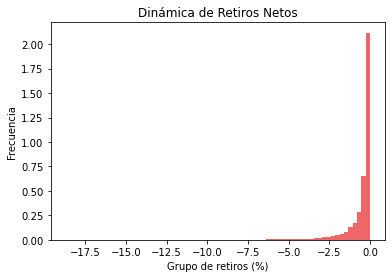

4952


In [25]:
#3.3 Comportamiento General de retiros
#    Respecto a la industria como se comportan los retiros Netos
datosBrutos['RetiroNetoPct'] = (datosBrutos['MovClient'] - \
                                datosBrutos['MovCorp'] - \
                                datosBrutos['MovPens'] - \
                                datosBrutos['MovDifPens'] - \
                                datosBrutos['OtrasComis'] - \
                                datosBrutos['MovRentVital'] - \
                                datosBrutos['OtrasComis'])/datosBrutos['VlrCierreAyer']
#   base especial para trabajar con los datos de retiros netos negativos
retirosNegInd = datosBrutos.loc[((datosBrutos['RetiroNetoPct']<0) & \
                                (datosBrutos['RetiroNetoPct']>-0.1) & \
                                 (datosBrutos['CodEnt']!=42)),
                                'RetiroNetoPct']
retirosNegDav = datosBrutos.loc[((datosBrutos['RetiroNetoPct']<0) & \
                                (datosBrutos['RetiroNetoPct']>-0.7) & \
                                 (datosBrutos['CodEnt']==42)),
                                'RetiroNetoPct']

retirosNegDav= retirosNegDav *100
# se grafica el porcentaje de cuentas por cada grupo de resultados
#plt.hist(retirosNegInd, bins=40,alpha=0.6, label='Industria',density=True,color='#008000')
plt.hist(retirosNegDav,bins=70, alpha=0.6, label='Davivienda Fcd',density=True,color='#E50000')
#plt.legend(loc='upper left')

plt.title("Dinámica de Retiros Netos")
plt.xlabel("Grupo de retiros (%)")
plt.ylabel("Frecuencia")
plt.show()
print(retirosNegDav.shape[0])
#del(retirosNegInd)
#del(retirosNegDav)

Retiros mayores al 1% representan el: 14.96% del total de retiros de la serie


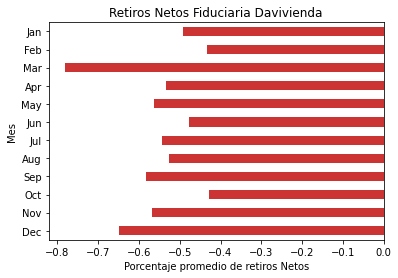

In [26]:
#3.4 Es de interes saber en qué meses del año y en que días de la semana se concentran los retiros para fiduciaria davivienda
#    Serie de retiros entre -1% y -80%
retirosNegDavUno = datosBrutos.loc[((datosBrutos['RetiroNetoPct']<-0.01) & \
                                (datosBrutos['RetiroNetoPct']>-0.8) & \
                                 (datosBrutos['CodEnt']==42)),
                                ['RetiroNetoPct','Mes']]

#    Cúal es el retiro promedio entre el 0%  y -80% por cada mes?
retirosNegDav = datosBrutos.loc[((datosBrutos['RetiroNetoPct']<0) & \
                                (datosBrutos['RetiroNetoPct']>-0.8) & \
                                 (datosBrutos['CodEnt']==42)),
                                ['RetiroNetoPct','Mes']]

#   cual es el porcentaje de retiros netos entre -1% y -80% dentro del total de retiros
pctRet = retirosNegDavUno.shape[0] / retirosNegDav.shape[0]
print('Retiros mayores al 1% representan el: ' + str(round(pctRet * 100,2)) + '% del total de retiros de la serie')

#   calculo del promedio de retiros por mes
retirosNegDav = retirosNegDav.pivot_table(index='Mes',
                                          values='RetiroNetoPct',
                                          aggfunc='mean').reset_index()

months = {"Jan":0, "Feb":1, "Mar":2, "Apr":3, "May":4, "Jun":5, "Jul":6, 
          "Aug":7, "Sep":8, "Oct":9, "Nov":10, "Dec":11 }

retirosNegDav['MesInt'] = retirosNegDav.apply(lambda x: months[x['Mes']], axis=1)
retirosNegDav.sort_values('MesInt', inplace=True, ascending=False)
retirosNegDav['RetiroNetoPct'] = retirosNegDav['RetiroNetoPct'] * 100

ax = retirosNegDav.plot(kind='barh',
                        x='Mes',
                        y='RetiroNetoPct',
                        sort_columns=True,
                        color='#c00000',
                        alpha=0.8)
ax.get_legend().remove()
ax.set_xlabel('Porcentaje promedio de retiros Netos')
ax.set_title("Retiros Netos Fiduciaria Davivienda")
plt.show()
del(retirosNegDavUno,retirosNegDav)

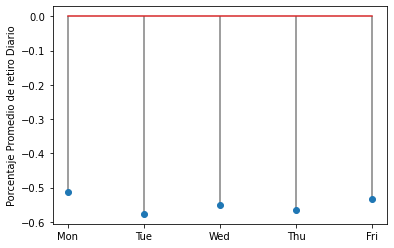

In [27]:
#    Existe algún dia de la semana que presente en promedio niveles de reitors mayores?
retirosNegDia = datosBrutos.loc[((datosBrutos['RetiroNetoPct']<0) & \
                                (datosBrutos['RetiroNetoPct']>-0.8) & \
                                 (datosBrutos['CodEnt']==42)),
                                ['RetiroNetoPct','DiaStr']]
#   calculo del promedio de retiros por día
retirosNegDia = retirosNegDia.pivot_table(index='DiaStr',
                                          values='RetiroNetoPct',
                                          aggfunc='mean').reset_index()
days = {"Mon":0, "Tue":1, "Wed":2, "Thu":3, "Fri":4}
retirosNegDia['DiaInt'] = retirosNegDia.apply(lambda x: days[x['DiaStr']],
                                              axis=1)
retirosNegDia.sort_values('DiaInt', ascending=True, inplace=True)
retirosNegDia['RetiroNetoPct'] = retirosNegDia['RetiroNetoPct'] * 100

(markers, stemlines, baseline) = plt.stem(retirosNegDia['RetiroNetoPct'])
plt.setp(stemlines, linestyle="-", color="gray", linewidth=1.5 )
plt.xticks(retirosNegDia['DiaInt'], retirosNegDia['DiaStr'])
plt.ylabel('Porcentaje Promedio de retiro Diario')
plt.show()
#del(retirosNegDia)

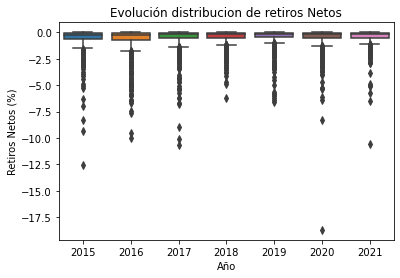

In [31]:
#3.5 Dadas las evidencias que llevan a pensar en una homogeneidad en los niveles de Retiros, realmente es así?
retirosNegDia = datosBrutos.loc[((datosBrutos['RetiroNetoPct']<0) & \
                                (datosBrutos['RetiroNetoPct']>-0.8) & \
                                 (datosBrutos['CodEnt']==42)),
                                ['RetiroNetoPct','Ano']]
retirosNegDia['RetiroNetoPct'] = retirosNegDia['RetiroNetoPct']*100
#fig, ax = plt.subplots()
#ax.boxplot(retirosNegDia)

#plt.show()

sns.boxplot(x='Ano', y='RetiroNetoPct', data=retirosNegDia)
plt.ylabel("Retiros Netos (%)")
plt.xlabel("Año")
plt.title("Evolución distribucion de retiros Netos")
plt.show()

In [37]:
numFdos = datosBrutos.loc[datosBrutos['CodEnt'] == 42, 'CodFdo'].drop_duplicates()
print('en total se conservan : ' +str(int(numFdos.shape[0])) + ' fondos dentro del análisis de fiduciaria Davivienda')
numFdos

en total se conservan : 8 fondos dentro del análisis de fiduciaria Davivienda


122     9996.0
123    10114.0
124    10145.0
125    10168.0
126    27430.0
127    27431.0
128    27432.0
129    47595.0
Name: CodFdo, dtype: float64

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000  0.021419
Ret                 0.021419  1.000000


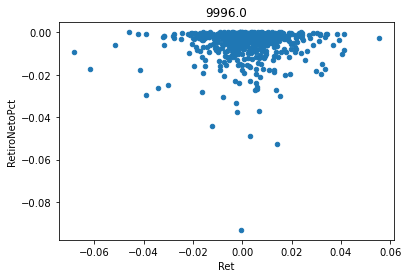

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000  0.214303
Ret                 0.214303  1.000000


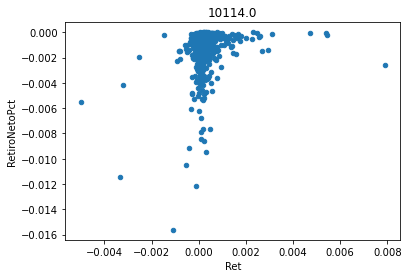

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000  0.027026
Ret                 0.027026  1.000000


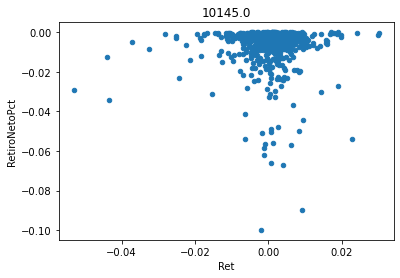

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000 -0.033721
Ret                -0.033721  1.000000


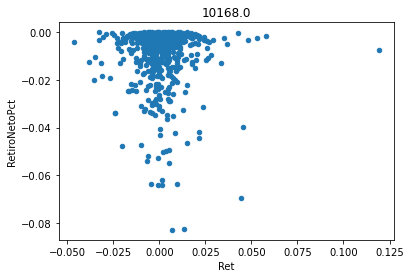

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000  0.040538
Ret                 0.040538  1.000000


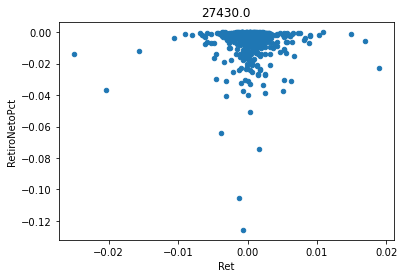

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000 -0.026017
Ret                -0.026017  1.000000


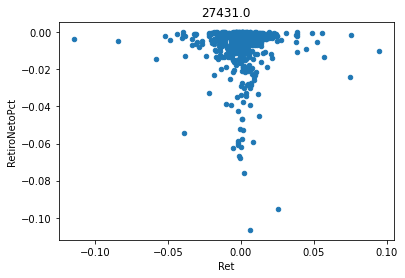

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000  0.421475
Ret                 0.421475  1.000000


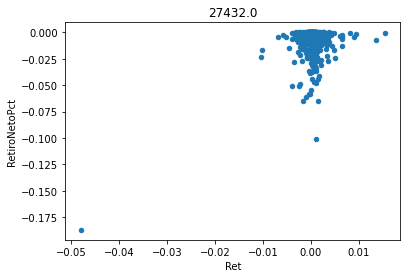

               RetiroNetoPct       Ret
RetiroNetoPct       1.000000  0.049308
Ret                 0.049308  1.000000


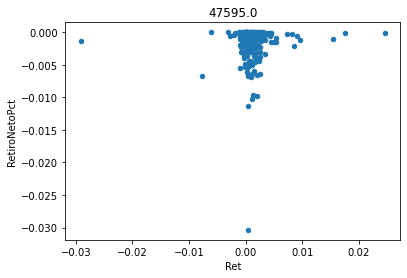

In [41]:
#3.6 Aproximaxión a la relación entre el retorno del portafolio 
for fdo in numFdos:
    datosFdo = datosBrutos.loc[((datosBrutos['CodEnt'] == 42) & \
                                (datosBrutos['CodFdo'] == fdo) & \
                                (datosBrutos['RetiroNetoPct'] <0)),
                                ['Fecha','VlrUnd','RetiroNetoPct']]
    datosFdo['Ret'] = datosFdo['VlrUnd'].pct_change(1)
    print(datosFdo[['RetiroNetoPct','Ret']].corr(method='pearson'))
    datosFdo.plot(kind='scatter',
                  x='Ret',
                  y='RetiroNetoPct')
    plt.title(fdo)
    plt.show()

<AxesSubplot:xlabel='Ret', ylabel='RetiroNetoPct'>

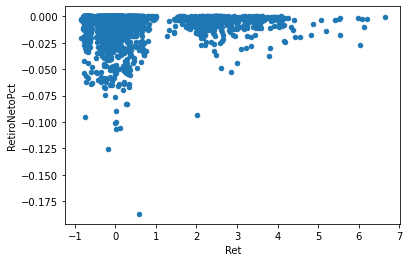

In [34]:
datosFdo = datosBrutos.loc[((datosBrutos['CodEnt'] == 42) & \
                                (datosBrutos['RetiroNetoPct'] <0)),
                                ['Fecha','VlrUnd','RetiroNetoPct']]
datosFdo['Ret'] = datosFdo['VlrUnd'].pct_change(1)

datosFdo.plot(kind='scatter',
               x='Ret',
               y='RetiroNetoPct')

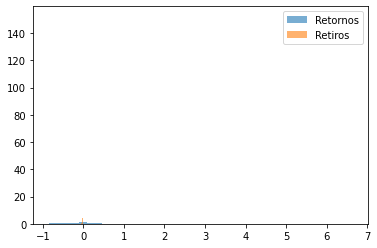

In [35]:
plt.hist(datosFdo['Ret'], bins=40,alpha=0.6, label='Retornos',density=True)
plt.hist(datosFdo['RetiroNetoPct'], bins=40,alpha=0.6, label='Retiros',density=True)
plt.legend()
plt.show()

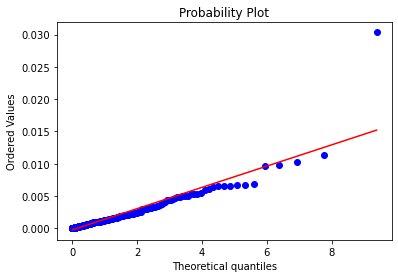

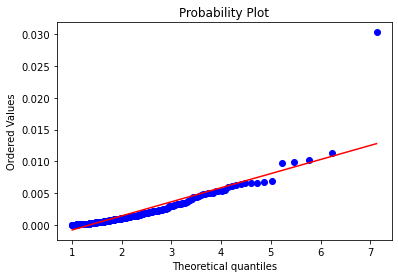

In [100]:
stats.probplot(abs(datosFdo['RetiroNetoPct']),sparams=(1), dist="chi2", plot=plt)
plt.show()
stats.probplot(abs(datosFdo['RetiroNetoPct']),sparams=(1), dist="expon", plot=plt)
plt.show()



In [102]:
stats.expon.fit(abs(datosFdo['RetiroNetoPct']))

(9.051293816084226e-08, 0.0013964620712643796)

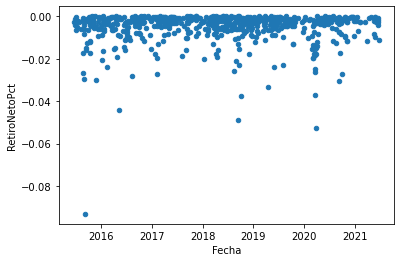

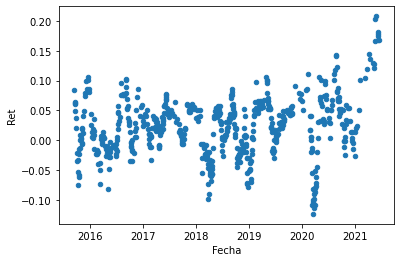

In [35]:
datosAcc[datosAcc['RetiroNetoPct']<0].plot(kind='scatter',
                                           x='Fecha',
                                           y='RetiroNetoPct')
datosAcc[datosAcc['RetiroNetoPct']<0].plot(kind='scatter',
                                           x='Fecha',
                                           y='Ret')
plt.show()

In [65]:
retirosP = datosBrutos.loc[((datosBrutos['CodEnt'] == 42)),]
retirosP.to_excel('dav2.xlsx')